### Important Note
This notebook is designed to be run on [Kaggle](https://www.kaggle.com/) due to its integration with the "Skin Cancer ISIC Images" dataset. 
Please ensure you have access to the dataset by either:

- Running this notebook directly on Kaggle, where the dataset is available.
- Downloading the dataset manually from Kaggle and setting up the file paths if running locally.


In [94]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [95]:
import numpy as np
import pandas as pd
from skimage import exposure
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import cv2
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)       

## Load Data

In [96]:
# Data Loading
def load_data(data_dir):
    """
    Load images and labels from directory
    Args:
        data_dir: Path to data directory
    Returns:
        images: numpy array of images
        labels: numpy array of labels
        class_names: list of class names
    """
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in tqdm(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(class_idx)
    one_hot_labels = to_categorical(labels)

    return np.array(images), np.array(one_hot_labels), class_names


## EDA

In [97]:
def perform_eda(images, labels, class_names):
    """
    Perform Exploratory Data Analysis specific to skin cancer dataset
    Args:
        images: numpy array of images
        labels: numpy array of labels
        class_names: list of class names
    """
    print("=== Dataset Analysis ===")
    
    # 1. Basic Dataset Statistics
    print(f"\nTotal number of images: {len(images)}")
    print(f"Image dimensions: {images[0].shape}")
    print(f"Number of classes: {len(class_names)}")
    
    # 2. Class Distribution
    class_counts = np.sum(labels, axis=0)  # Sum each column for one-hot labels
    class_distribution = {}
    print("\nClass Distribution:")
    for i, count in enumerate(class_counts):
        percentage = (count / len(labels)) * 100
        print(f"{class_names[i]}: {int(count)} images ({percentage:.2f}%)")
        class_distribution[class_names[i]] = int(count)
    
    
    # 3. Visualize Class Distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
    plt.title('Distribution of Classes')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()
    
    # 4. Image Quality Analysis
    print("\nAnalyzing Image Quality...")
    brightness_values = []
    contrast_values = []
    
    for img in tqdm(images):
        # Calculate brightness
        brightness = np.mean(img)
        brightness_values.append(brightness)
        
        # Calculate contrast
        contrast = np.std(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
        contrast_values.append(contrast)
    
    # Plot quality metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(brightness_values, ax=ax1)
    ax1.set_title('Brightness Distribution')
    ax1.set_xlabel('Mean Brightness')
    
    sns.histplot(contrast_values, ax=ax2)
    ax2.set_title('Contrast Distribution')
    ax2.set_xlabel('Contrast (Standard Deviation)')
    
    plt.tight_layout()
    plt.show()
    
    return class_distribution, brightness_values, contrast_values

def enhance_image_quality(image):
    """
    Enhance image quality using CLAHE
    Args:
        image: input image
    Returns:
        enhanced image
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab[...,0] = clahe.apply(lab[...,0])
    
    # Convert back to RGB
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    return enhanced

def handle_class_imbalance(images, labels, class_distribution):
    """
    Handle class imbalance by upsampling minority class to match majority class
    Args:
        images: numpy array of images
        labels: one-hot encoded labels
        class_distribution: dictionary of class distributions
    Returns:
        balanced images and labels
    """
    # Get class counts from one-hot labels
    class_counts = np.sum(labels, axis=0)
    majority_size = int(max(class_counts))
    
    # Get indices for each class
    class_indices = [np.where(labels[:, i] == 1)[0] for i in range(len(class_counts))]
    
    balanced_images = []
    balanced_labels = []
    
    for i, indices in enumerate(class_indices):
        current_size = len(indices)
        if current_size < majority_size:
            # Oversample minority class
            n_samples_needed = majority_size - current_size
            resampled_indices = np.random.choice(indices, n_samples_needed, replace=True)
            all_indices = np.concatenate([indices, resampled_indices])
        else:
            all_indices = indices
            
        balanced_images.extend(images[all_indices])
        balanced_labels.extend(labels[all_indices])
    
    balanced_images = np.array(balanced_images)
    balanced_labels = np.array(balanced_labels)
    
    print("\nAfter balancing:")
    print(f"Total samples: {len(balanced_images)}")
    print(f"Class distribution: {np.sum(balanced_labels, axis=0)}")
    
    return balanced_images, balanced_labels

def visualize_preprocessing(image):
    """
    Visualize preprocessing steps
    Args:
        image: input image
    """
    # Original
    plt.figure(figsize=(12, 4))
    
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    
    # Enhanced
    enhanced = enhance_image_quality(image)
    plt.subplot(132)
    plt.imshow(enhanced)
    plt.title('Enhanced')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## Preprocessing
Resize & Normalize

In [98]:
def preprocess_images(images, target_size=(28, 28)):
    """
    Preprocess images for model input
    Args:
        images: numpy array of images
        target_size: tuple of target image dimensions
    Returns:
        preprocessed_images: numpy array of preprocessed images
    """
    preprocessed_images = []
    for img in tqdm(images):
        # Resize image
        img_resized = cv2.resize(img, target_size)
        
        # Normalize pixel values
        img_normalized = img_resized / 255.0
        
        preprocessed_images.append(img_normalized)
    
    return np.array(preprocessed_images)

## Create Paper's Model

In [99]:
def create_model(input_shape, num_classes):
    """
    Create CNN model based on the paper's architecture
    Args:
        input_shape: tuple of input image shape
        num_classes: number of classes
    Returns:
        model: compiled keras model
    """
    # Use Input layer as recommended
    inputs = tf.keras.Input(shape=input_shape)
    
    # First convolutional block
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(2, 2)(x)
    
    # Second convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    
    # Convolutional layer with padding='same'
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Fourth convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    
    # Flatten and dense layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## Create DataLoader

In [100]:
def create_dataloader(images, labels, batch_size=128, shuffle=True, augment=True):
    """
    Create TensorFlow dataset with your preprocessing pipeline
    Args:
        images: numpy array of images
        labels: numpy array of labels
        batch_size: batch size
        shuffle: whether to shuffle data
        augment: whether to apply augmentation
    Returns:
        tf.data.Dataset: configured dataset
    """
    # Convert to tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Shuffle if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    
    # Define preprocessing function
    def process_image(image, label):
        """Apply your preprocessing pipeline"""
        
        if augment:
            # Convert to float32 if needed
            image = tf.cast(image, tf.float32)
            # 1. Random horizontal flip
            if tf.random.uniform([]) > 0.5:
                image = tf.image.flip_left_right(image)
            # 2. Random width shift (20%)
            if tf.random.uniform([]) > 0.5:
                w_shift = tf.random.uniform([], -0.2, 0.2)
                image = tf.image.stateless_random_crop(
                    tf.pad(image, [[0, 0], [2, 2], [0, 0]], mode='SYMMETRIC'),
                    size=tf.shape(image),
                    seed=tf.random.uniform([2], 0, 1000, dtype=tf.int32)
                )
            # 3. Random height shift (20%)
            if tf.random.uniform([]) > 0.5:
                h_shift = tf.random.uniform([], -0.2, 0.2)
                image = tf.image.stateless_random_crop(
                    tf.pad(image, [[2, 2], [0, 0], [0, 0]], mode='SYMMETRIC'),
                    size=tf.shape(image),
                    seed=tf.random.uniform([2], 0, 1000, dtype=tf.int32)
                )
            # 4. Random rotation (simplified version using built-in tf operations)
            if tf.random.uniform([]) > 0.5:
                k = tf.random.uniform([], 0, 4, dtype=tf.int32)  # 0, 90, 180, or 270 degrees
                image = tf.image.rot90(image, k)
            # Ensure output shape is correct and values are in valid range
            image = tf.clip_by_value(image, 0, 1)
            
        return image, label
    
    # Apply preprocessing
    dataset = dataset.map(
        process_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def prepare_data_pipeline(data_dir, img_size=(28, 28), batch_size=128):
    """
    Complete data preparation pipeline using tf.data.Dataset
    """
    # 1. Load raw images and labels
    print("Loading and preprocessing images...")
    images, labels, class_names = load_data(data_dir)
    
    # 2. Enhance image quality
    print("\nEnhancing image quality...")
    enhanced_images = []
    for img in tqdm(images):
        enhanced = enhance_image_quality(img)
        enhanced_images.append(enhanced)
    enhanced_images = np.array(enhanced_images)
    
    # 3. Handle class imbalance
    print("\nHandling class imbalance...")
    class_distribution = {name: np.sum(labels[:, i]) 
                        for i, name in enumerate(class_names)}
    balanced_images, balanced_labels = handle_class_imbalance(
        enhanced_images, labels, class_distribution
    )
    
    # 4. Split data
    print("\nSplitting dataset...")
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        balanced_images, balanced_labels,
        test_size=0.2,
        random_state=42,
        stratify=np.argmax(balanced_labels, axis=1)
    )
    
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels,
        test_size=0.5,
        random_state=42,
        stratify=np.argmax(temp_labels, axis=1)
    )
    
    # 5. Preprocess and create dataloaders
    print("\nCreating dataloaders...")
    train_dataset = create_dataloader(
        train_images, train_labels,
        batch_size=batch_size,
        shuffle=True,
        augment=True
    )
    
    val_dataset = create_dataloader(
        val_images, val_labels,
        batch_size=batch_size,
        shuffle=False,
        augment=False
    )
    
    test_dataset = create_dataloader(
        test_images, test_labels,
        batch_size=batch_size,
        shuffle=False,
        augment=False
    )
    
    return train_dataset, val_dataset, test_dataset, class_names

## Train Model Function

In [101]:
def train_model(model, train_dataset, val_dataset, epochs=50):
    """
    Train the model using tf.data.Dataset
    """
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train model using datasets
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    
    return history

In [102]:
def print_simple_summary(model):
    """
    Print a simple model summary using Keras built-in method
    Args:
        model: keras model
    """
    print("\nModel Architecture:")
    model.summary()
    
    # Print layer types without parameter counting
    print("\nLayer Types:")
    for idx, layer in enumerate(model.layers):
        print(f"Layer {idx}: {layer.__class__.__name__}")

In [103]:
def visualize_predictions(model, test_images, test_labels, class_names, num_examples=5):
    """
    Visualize model predictions on test images
    
    Args:
        model: trained keras model
        test_images: numpy array of test images
        test_labels: numpy array of test labels (binary or one-hot)
        class_names: list of class names
        num_examples: number of examples to visualize
    """
    # Get predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype(int)
    
    # Convert labels to class indices if they're one-hot encoded
    true_classes = np.argmax(test_labels, axis=1) if len(test_labels.shape) > 1 else test_labels
    
    # Select random examples
    indices = np.random.choice(len(test_images), num_examples, replace=False)
    
    # Create figure
    plt.figure(figsize=(15, 3))
    
    # Plot each example
    for i, idx in enumerate(indices):
        plt.subplot(1, num_examples, i + 1)
        
        # Display image
        img = test_images[idx]
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap='gray')
            
        # Get true and predicted labels
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        
        # Set title color based on prediction correctness
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Add title with true and predicted labels
        plt.title(f'True: {true_label}\nPred: {pred_label}', 
                 color=title_color,
                 fontsize=10,
                 pad=5)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for visualized examples
    correct = sum(true_classes[indices] == predicted_classes[indices])
    print(f"\nAccuracy on visualized examples: {correct}/{num_examples} ({100*correct/num_examples:.1f}%)")
    
    # Add confidence scores for predictions
    print("\nDetailed predictions for visualized examples:")
    for idx in indices:
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        
        if predictions.shape[1] > 1:  # multi-class
            confidence = predictions[idx][predicted_classes[idx]] * 100
        else:  # binary
            confidence = (predictions[idx][0] if predicted_classes[idx] == 1 else (1 - predictions[idx][0])) * 100
            
        status = "✓" if true_label == pred_label else "✗"
        print(f"{status} True: {true_label:15} Predicted: {pred_label:15} Confidence: {confidence:.1f}%")

## Evaluate Model

In [104]:
def evaluate_model(model, test_images, test_labels, class_names):
    """
    Evaluate model performance with support for both binary and one-hot encoded labels
    
    Args:
        model: trained keras model
        test_images: numpy array of test images
        test_labels: numpy array of test labels (binary or one-hot)
        class_names: list of class names
    """
    # Get predictions
    predictions = model.predict(test_images)
    
    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1) if predictions.shape[1] > 1 else (predictions > 0.5).astype(int)
    
    # Convert one-hot test labels to class indices if needed
    true_classes = np.argmax(test_labels, axis=1) if len(test_labels.shape) > 1 else test_labels
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names))
    
    # Plot confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Plot ROC curve for binary classification
    if len(class_names) == 2:
        # Handle binary case
        if len(test_labels.shape) > 1:  # one-hot encoded
            true_binary = test_labels[:, 1]  # assume positive class is index 1
        else:
            true_binary = test_labels
            
        if predictions.shape[1] > 1:  # model outputs probabilities for both classes
            pred_binary = predictions[:, 1]  # use probability of positive class
        else:
            pred_binary = predictions.ravel()
            
        fpr, tpr, _ = roc_curve(true_binary, pred_binary)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
    
    # Add detailed metrics
    print("\nDetailed Metrics:")
    for i, class_name in enumerate(class_names):
        true_binary = (true_classes == i)
        pred_binary = (predicted_classes == i)
        
        tn, fp, fn, tp = confusion_matrix(true_binary, pred_binary).ravel()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\nClass: {class_name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"True Positives: {tp}")
        print(f"False Positives: {fp}")
        print(f"True Negatives: {tn}")
        print(f"False Negatives: {fn}")

# Helper function to convert labels to one-hot encoding if needed
def prepare_labels(labels, num_classes):
    """
    Convert labels to one-hot encoding if they aren't already
    
    Args:
        labels: numpy array of labels
        num_classes: number of classes
    Returns:
        one_hot_labels: one-hot encoded labels
    """
    if len(labels.shape) == 1:
        return tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    return labels



In [105]:
def visualize_model_architecture(model):
    """
    Create and save a visualization of the model architecture
    Args:
        model: keras model
    """
    try:
        from tensorflow.keras.utils import plot_model
        
        # Create visualization
        plot_model(
            model,
            to_file='model_architecture.png',
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB'
        )
        
        # Display using matplotlib
        from IPython.display import Image, display
        display(Image('model_architecture.png'))
        
    except Exception as e:
        print(f"Could not create model visualization: {str(e)}")
        print("Please ensure graphviz is installed:")
        print("!apt-get install graphviz")


In [106]:
def plot_training_history(history):
    """
    Plot training history
    Args:
        history: training history object
    """
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [107]:
# Load data
DATA_DIR = '/kaggle/input/skin-cancer-isic-images/'
images, labels, class_names = load_data(DATA_DIR)

100%|██████████| 1497/1497 [00:04<00:00, 353.34it/s]


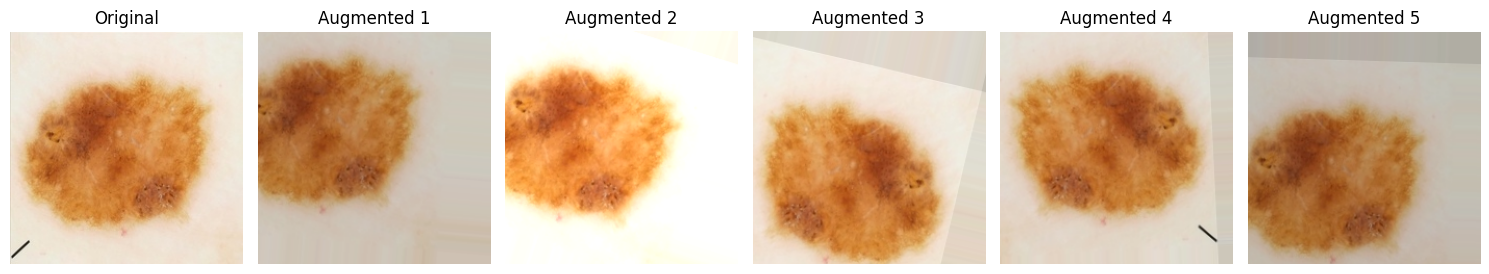

In [108]:
def show_augmentation_examples(image):
    """
    Simpler function to demonstrate augmentation effects
    """
    # Create generator
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Prepare image
    image = np.expand_dims(image, 0)
    
    # Create figure
    plt.figure(figsize=(15, 3))
    
    # Show original
    plt.subplot(1, 6, 1)
    plt.imshow(image[0].astype(np.uint8))
    plt.title('Original')
    plt.axis('off')
    
    # Generate and show augmented images
    it = datagen.flow(image, batch_size=1)
    for i in range(5):
        batch = it.__next__()
        plt.subplot(1, 6, i + 2)
        plt.imshow(batch[0].astype(np.uint8))
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Try the simpler version
try:
    if 'images' in locals() and len(images) > 0:
        show_augmentation_examples(images[0])
    else:
        print("Please load your images first!")
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [109]:
# Simulating the training process with a small dataset
def demonstrate_epoch_processing():
    """
    Demonstrate how images are processed in one epoch
    """
    # Simulate a tiny dataset of 5 images
    print("Example with 5 images in dataset:")
    print("\nEPOCH 1:")
    for i in range(5):
        print(f"Step {i+1}: Original Image {i+1} → Gets augmented → Model trains on ONLY the augmented version")
    
    print("\nEPOCH 2:")
    for i in range(5):
        print(f"Step {i+1}: Original Image {i+1} → Gets differently augmented → Model trains on ONLY the new augmented version")

# Run the demonstration
demonstrate_epoch_processing()

print("\n=== KEY POINTS ===")
print("1. In each epoch:")
print("   - Each original image is used exactly once")
print("   - It gets randomly augmented")
print("   - Only the augmented version is used for training")
print("   - Original image is NOT used for training")
print("\n2. If you have 1000 images:")
print("   - Each epoch still processes 1000 images (augmented versions)")
print("   - NOT 2000 images (it doesn't use both original and augmented)")
print("\n3. The benefit comes from:")
print("   - Each epoch sees different variations of the same images")
print("   - But the number of images per epoch stays the same")

Example with 5 images in dataset:

EPOCH 1:
Step 1: Original Image 1 → Gets augmented → Model trains on ONLY the augmented version
Step 2: Original Image 2 → Gets augmented → Model trains on ONLY the augmented version
Step 3: Original Image 3 → Gets augmented → Model trains on ONLY the augmented version
Step 4: Original Image 4 → Gets augmented → Model trains on ONLY the augmented version
Step 5: Original Image 5 → Gets augmented → Model trains on ONLY the augmented version

EPOCH 2:
Step 1: Original Image 1 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 2: Original Image 2 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 3: Original Image 3 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 4: Original Image 4 → Gets differently augmented → Model trains on ONLY the new augmented version
Step 5: Original Image 5 → Gets differently augmented → Model trains on ONLY the new augmented vers

## Performance 

In [110]:
import time
import psutil
import tensorflow as tf
import numpy as np
from memory_profiler import profile
import matplotlib.pyplot as plt

class PerformanceComparison:
    def __init__(self, train_images, train_labels, val_images, val_labels, batch_size=128):
        self.train_images = train_images
        self.train_labels = train_labels
        self.val_images = val_images
        self.val_labels = val_labels
        self.batch_size = batch_size
        self.results = {}

    def measure_memory(self, func):
        """Measure memory usage of a function"""
        process = psutil.Process()
        mem_before = process.memory_info().rss
        result = func()
        mem_after = process.memory_info().rss
        memory_used = (mem_after - mem_before) / 1024 / 1024  # Convert to MB
        return memory_used, result

    def measure_time(self, func):
        """Measure execution time of a function"""
        start_time = time.time()
        result = func()
        end_time = time.time()
        return end_time - start_time, result

    def test_dataloader_performance(self):
        """Test tf.data.Dataset performance"""
        def create_dataset():
            dataset = create_dataloader(
                self.train_images,
                self.train_labels,
                batch_size=self.batch_size,
                shuffle=True,
                augment=True
            )
            return dataset

        # Measure memory and time
        memory_usage, _ = self.measure_memory(create_dataset)
        execution_time, dataset = self.measure_time(create_dataset)

        # Measure data loading speed
        start_time = time.time()
        batches = 0
        for _ in dataset.take(100):  # Test with 100 batches
            batches += 1
        loading_time = time.time() - start_time
        
        self.results['dataloader'] = {
            'memory_usage': memory_usage,
            'creation_time': execution_time,
            'batch_loading_time': loading_time / batches,
            'type': 'DataLoader'
        }

    def test_generator_performance(self):
        """Test ImageDataGenerator performance"""
        def create_generators():
            return create_data_generators(
                self.train_images,
                self.train_labels,
                self.val_images,
                self.val_labels,
                batch_size=self.batch_size
            )

        # Measure memory and time
        memory_usage, _ = self.measure_memory(create_generators)
        execution_time, (train_gen, _) = self.measure_time(create_generators)

        # Measure data loading speed
        start_time = time.time()
        batches = 0
        for _ in range(100):  # Test with 100 batches
            next(train_gen)
            batches += 1
        loading_time = time.time() - start_time

        self.results['generator'] = {
            'memory_usage': memory_usage,
            'creation_time': execution_time,
            'batch_loading_time': loading_time / batches,
            'type': 'ImageDataGenerator'
        }

    def run_comparison(self):
        """Run complete comparison"""
        print("Running performance comparison...")
        
        # Test both approaches
        self.test_dataloader_performance()
        self.test_generator_performance()
        
        # Print results
        print("\nPerformance Comparison Results:")
        print("-" * 50)
        metrics = ['memory_usage', 'creation_time', 'batch_loading_time']
        for metric in metrics:
            print(f"\n{metric.replace('_', ' ').title()}:")
            for approach in ['dataloader', 'generator']:
                value = self.results[approach][metric]
                if metric == 'memory_usage':
                    print(f"{self.results[approach]['type']}: {value:.2f} MB")
                else:
                    print(f"{self.results[approach]['type']}: {value:.4f} seconds")

        # Plot comparison
        self.plot_comparison()

    def plot_comparison(self):
        """Plot performance comparison"""
        metrics = ['memory_usage', 'creation_time', 'batch_loading_time']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, metric in enumerate(metrics):
            values = [self.results[approach][metric] for approach in ['dataloader', 'generator']]
            approaches = [self.results[approach]['type'] for approach in ['dataloader', 'generator']]
            
            axes[i].bar(approaches, values)
            axes[i].set_title(metric.replace('_', ' ').title())
            axes[i].set_ylabel('MB' if metric == 'memory_usage' else 'Seconds')
            
        plt.tight_layout()
        plt.show()

# Example usage
def compare_approaches(train_images, train_labels, val_images, val_labels):
    """
    Run complete comparison between DataLoader and ImageDataGenerator
    """
    # Initialize comparison
    comparison = PerformanceComparison(
        train_images=train_images,
        train_labels=train_labels,
        val_images=val_images,
        val_labels=val_labels,
        batch_size=128
    )
    
    # Run comparison
    comparison.run_comparison()
    
    return comparison.results

# Training comparison
def compare_training_performance(train_images, train_labels, val_images, val_labels,
                               epochs=5, batch_size=128):
    """
    Compare training performance between the two approaches
    """
    print("\nComparing Training Performance...")
    
    # Model creation function
    def create_test_model():
        return create_model(input_shape=(28, 28, 3), num_classes=len(np.unique(train_labels)))
    
    # Train with DataLoader
    print("\nTraining with DataLoader...")
    train_dataset = create_dataloader(train_images, train_labels, batch_size)
    val_dataset = create_dataloader(val_images, val_labels, batch_size, augment=False)
    
    model_dl = create_test_model()
    start_time = time.time()
    history_dl = model_dl.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    dl_time = time.time() - start_time
    
    # Train with ImageDataGenerator
    print("\nTraining with ImageDataGenerator...")
    train_gen, val_gen = create_data_generators(train_images, train_labels, 
                                              val_images, val_labels, batch_size)
    
    model_gen = create_test_model()
    start_time = time.time()
    history_gen = model_gen.fit(train_gen, validation_data=val_gen, epochs=epochs)
    gen_time = time.time() - start_time
    
    # Plot training comparison
    plt.figure(figsize=(15, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_dl.history['accuracy'], label='DataLoader - Train')
    plt.plot(history_dl.history['val_accuracy'], label='DataLoader - Val')
    plt.plot(history_gen.history['accuracy'], label='Generator - Train')
    plt.plot(history_gen.history['val_accuracy'], label='Generator - Val')
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_dl.history['loss'], label='DataLoader - Train')
    plt.plot(history_dl.history['val_loss'], label='DataLoader - Val')
    plt.plot(history_gen.history['loss'], label='Generator - Train')
    plt.plot(history_gen.history['val_loss'], label='Generator - Val')
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nTraining Time Comparison:")
    print(f"DataLoader: {dl_time:.2f} seconds")
    print(f"ImageDataGenerator: {gen_time:.2f} seconds")
    
    return {
        'dataloader': {
            'time': dl_time,
            'history': history_dl.history
        },
        'generator': {
            'time': gen_time,
            'history': history_gen.history
        }
    }

## Execute

Starting pipeline with performance monitoring...
1. Loading and analyzing data...


100%|██████████| 1497/1497 [00:04<00:00, 344.07it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)



2. Visualizing preprocessing steps on a sample image...
=== Dataset Analysis ===

Total number of images: 3297
Image dimensions: (224, 224, 3)
Number of classes: 2

Class Distribution:
benign: 1800 images (54.60%)
malignant: 1497 images (45.40%)


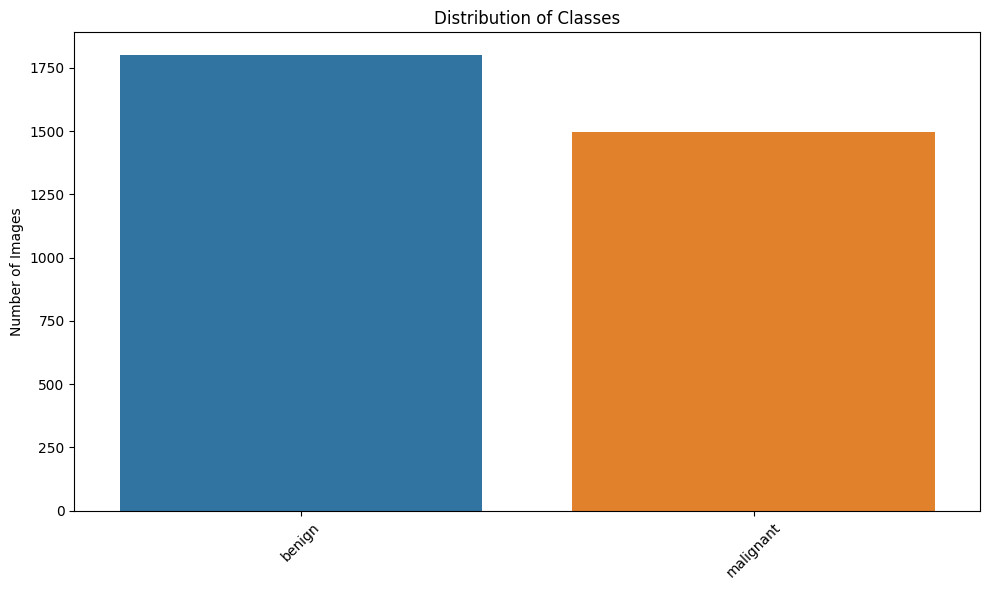


Analyzing Image Quality...


100%|██████████| 3297/3297 [00:00<00:00, 3347.82it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


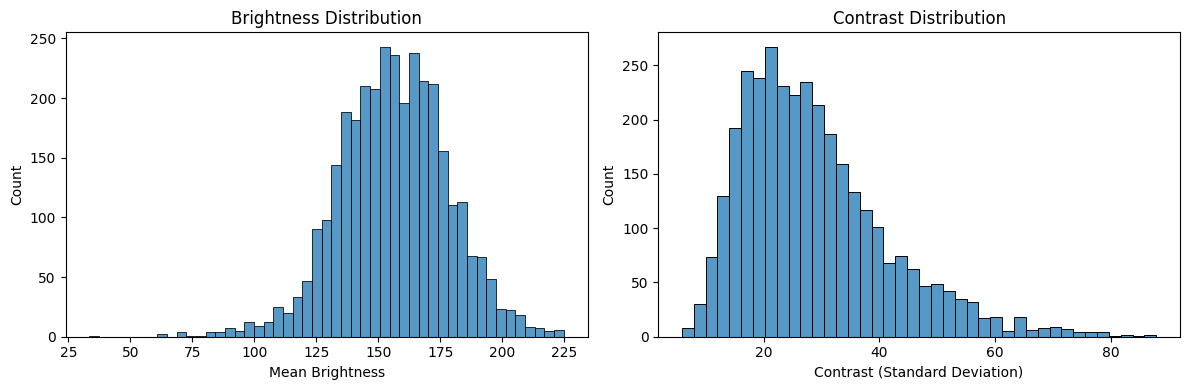


3. Enhancing image quality...


Enhancing images: 100%|██████████| 3297/3297 [00:05<00:00, 562.09it/s]



4. Handling class imbalance...

After balancing:
Total samples: 3600
Class distribution: [1800. 1800.]

5. Preprocessing images...


100%|██████████| 3600/3600 [00:00<00:00, 48767.20it/s]


6. Splitting data...

7. Creating and compiling model...

Model Architecture:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,418 (517.26 KB)

 Trainable params: 132,418 (517.26 KB)

 Non-trainable params: 0 (0.00 B)


Layer Types:
Layer 0: InputLayer
Layer 1: Conv2D
Layer 2: MaxPooling2D
Layer 3: Conv2D
Layer 4: MaxPooling2D
Layer 5: Conv2D
Layer 6: MaxPooling2D
Layer 7: Conv2D
Layer 8: MaxPooling2D
Layer 9: Flatten
Layer 10: Dense
Layer 11: Dense
Layer 12: Dense


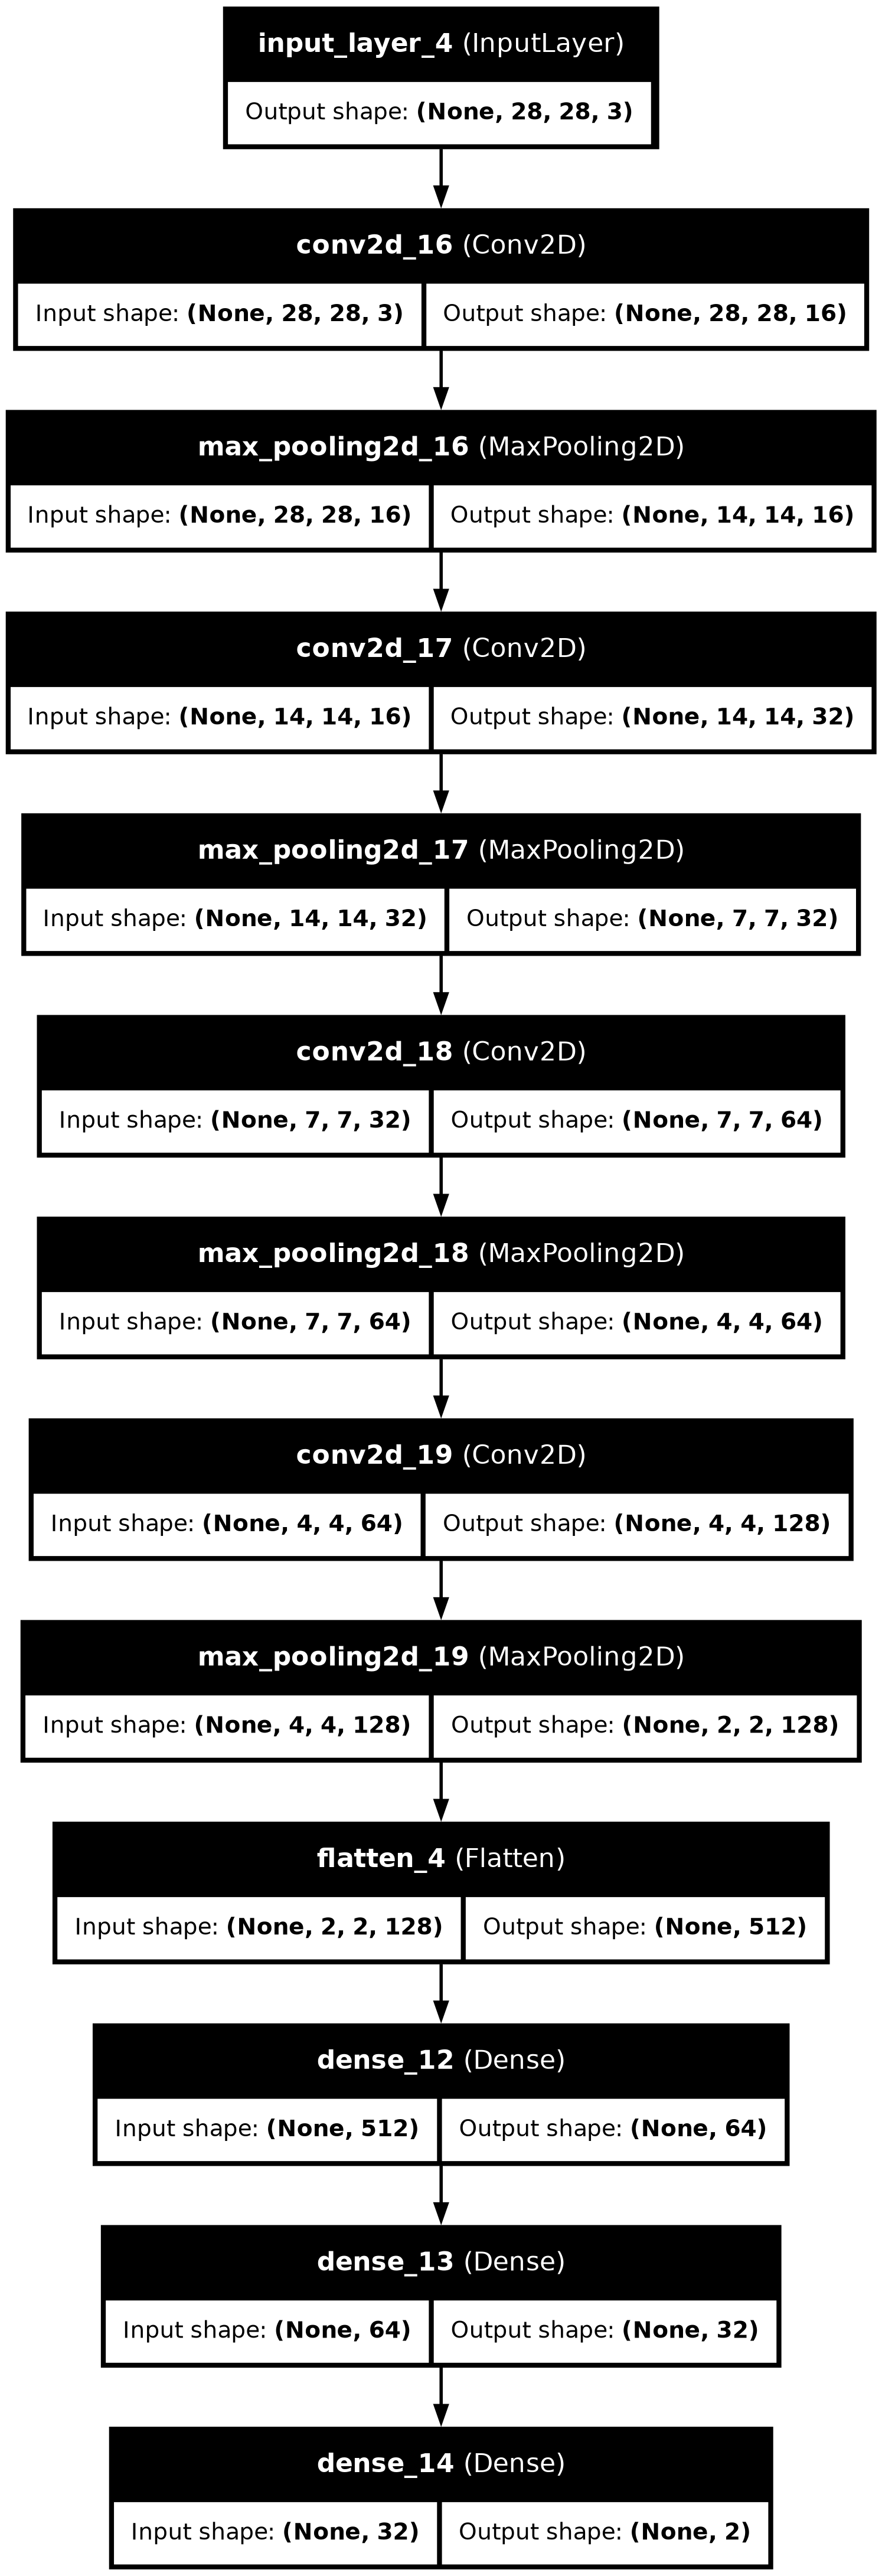


8. Creating data loaders...

9. Training model...
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5685 - loss: 0.6740
Epoch 1: val_accuracy improved from -inf to 0.79444, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5720 - loss: 0.6725 - val_accuracy: 0.7944 - val_loss: 0.4976 - learning_rate: 0.0010
Epoch 2/50
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7730 - loss: 0.4880
Epoch 2: val_accuracy improved from 0.79444 to 0.82500, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7754 - loss: 0.4825 - val_accuracy: 0.8250 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 3/50
19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8068 - loss: 0.4064
Epoch 3: val_accuracy improved from 0.82500 to 0.84167, saving model to best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8066 - loss: 0.4080 - val_accuracy: 0.8417 - val_loss: 0.3806 - learning_rate: 0.0010
Epoch 4/50
2

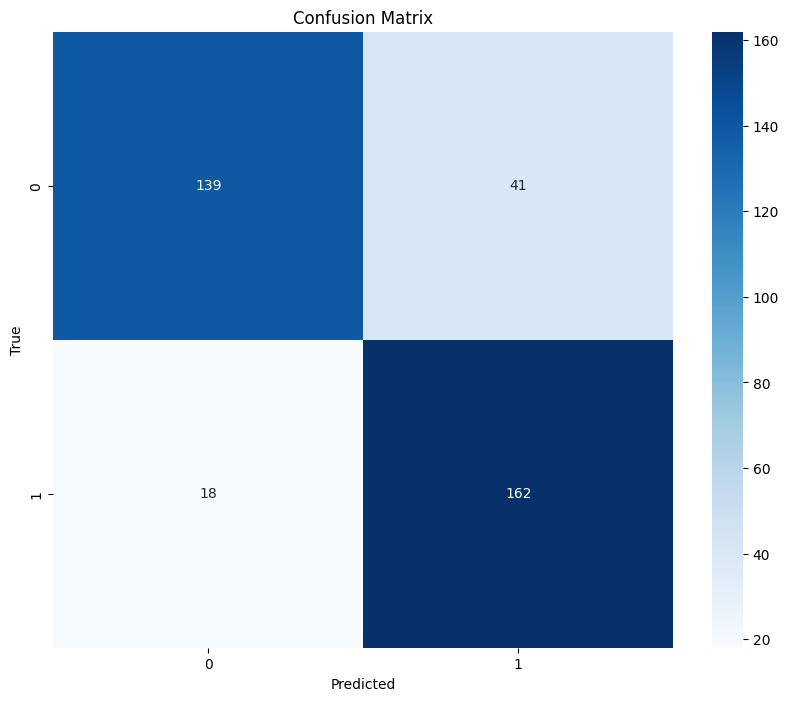

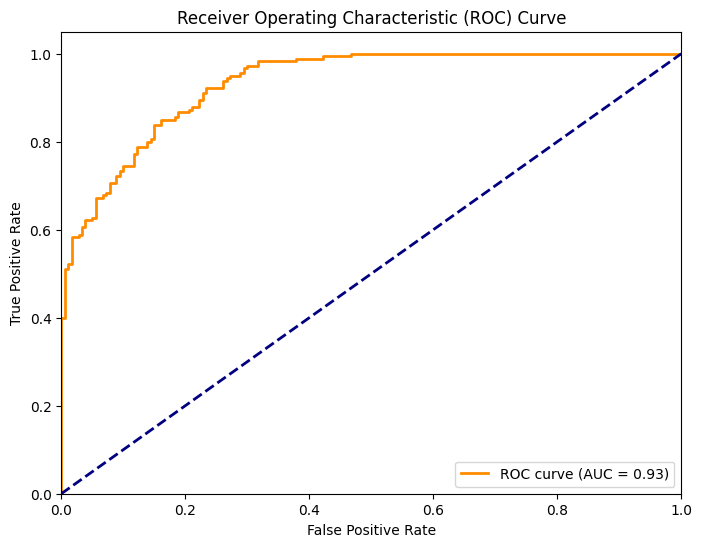


Detailed Metrics:

Class: benign
Accuracy: 0.8361
Precision: 0.8854
Recall: 0.7722
F1-score: 0.8249
True Positives: 139
False Positives: 18
True Negatives: 162
False Negatives: 41

Class: malignant
Accuracy: 0.8361
Precision: 0.7980
Recall: 0.9000
F1-score: 0.8460
True Positives: 162
False Positives: 41
True Negatives: 139
False Negatives: 18

11. Visualizing predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


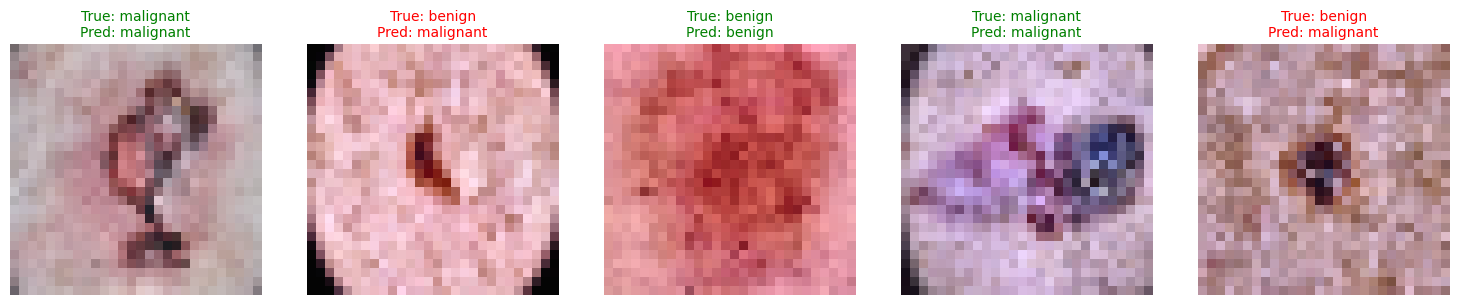


Accuracy on visualized examples: 3/5 (60.0%)

Detailed predictions for visualized examples:
✓ True: malignant       Predicted: malignant       Confidence: 95.2%
✗ True: benign          Predicted: malignant       Confidence: 68.8%
✓ True: benign          Predicted: benign          Confidence: 100.0%
✓ True: malignant       Predicted: malignant       Confidence: 98.9%
✗ True: benign          Predicted: malignant       Confidence: 83.8%

12. Plotting training history...


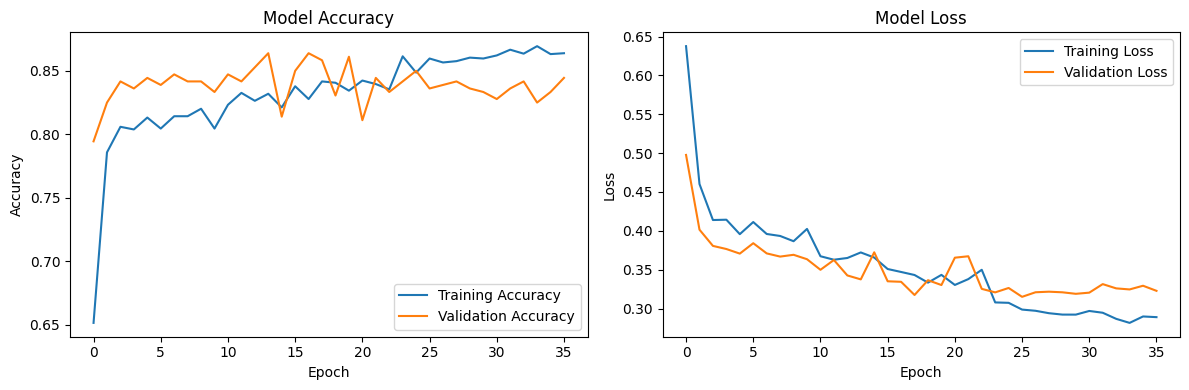


Performance Metrics:
--------------------------------------------------

Data Loading & EDA:
Time: 11.46 seconds
Memory: 3696.14 MB

Image Enhancement:
Time: 6.01 seconds
Memory: 4246.15 MB

Class Balancing:
Time: 0.32 seconds
Memory: 4763.40 MB

Preprocessing:
Time: 0.09 seconds
Memory: 4763.40 MB

Data Splitting:
Time: 0.02 seconds
Memory: 4763.40 MB

Model Creation:
Time: 0.57 seconds
Memory: 4763.40 MB

Model Training:
Time: 14.74 seconds
Memory: 4818.52 MB

Total Pipeline Time: 33.21 seconds


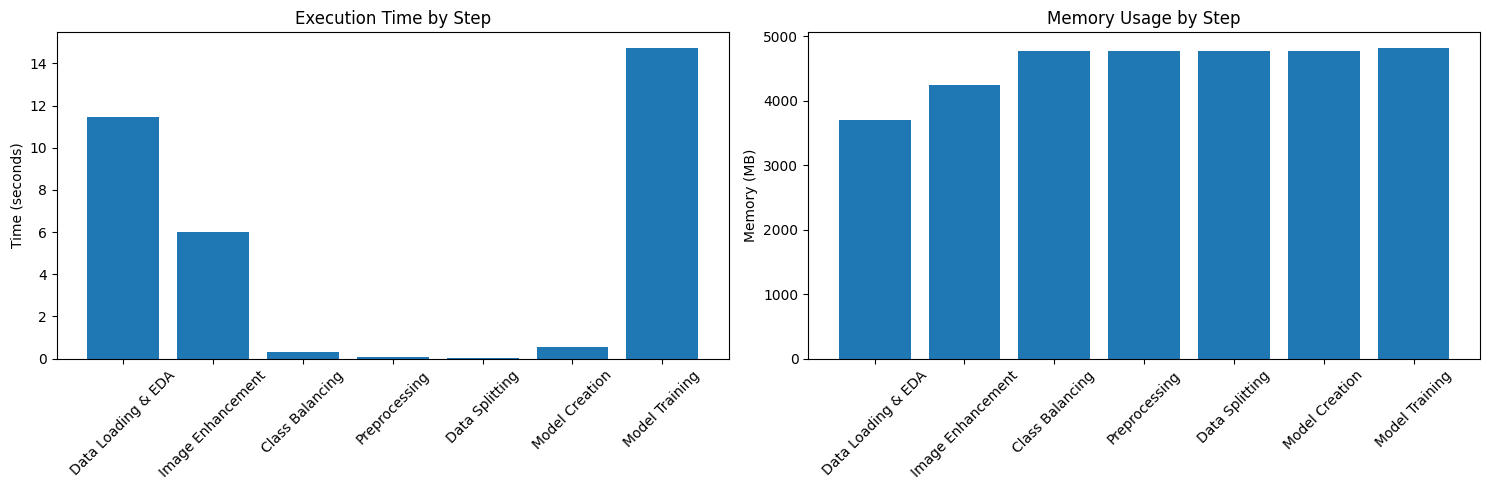

In [112]:
import time
import psutil
import tracemalloc
from contextlib import contextmanager

class PerformanceMonitor:
    def __init__(self):
        self.metrics = {}
        
    @contextmanager
    def measure_time(self, step_name):
        """Measure execution time of a code block"""
        start_time = time.time()
        yield
        end_time = time.time()
        execution_time = end_time - start_time
        
        self.metrics[step_name] = {
            'time': execution_time,
            'memory': psutil.Process().memory_info().rss / 1024 / 1024  # MB
        }
    
    def print_metrics(self):
        """Print all collected metrics"""
        print("\nPerformance Metrics:")
        print("-" * 50)
        total_time = 0
        for step, metrics in self.metrics.items():
            print(f"\n{step}:")
            print(f"Time: {metrics['time']:.2f} seconds")
            print(f"Memory: {metrics['memory']:.2f} MB")
            total_time += metrics['time']
        print("\nTotal Pipeline Time:", f"{total_time:.2f} seconds")

def execute_pipeline_with_metrics(data_dir, img_size=(28, 28), batch_size=128, epochs=50):
    """
    Execute pipeline with performance monitoring
    """
    monitor = PerformanceMonitor()

    try:
        # 1. Data Loading and EDA
        with monitor.measure_time("Data Loading & EDA"):
            print("1. Loading and analyzing data...")
            images, labels, class_names = load_data(data_dir)
            print("\n2. Visualizing preprocessing steps on a sample image...")
            class_distribution, _, _ = perform_eda(images, labels, class_names)
        
        # 2. Image Enhancement
        print("\n3. Enhancing image quality...")
        with monitor.measure_time("Image Enhancement"):
            enhanced_images = []
            for image in tqdm(images, desc="Enhancing images"):
                enhanced = enhance_image_quality(image)
                enhanced_images.append(enhanced)
            enhanced_images = np.array(enhanced_images)
        
        # 3. Class Balancing
        print("\n4. Handling class imbalance...")
        with monitor.measure_time("Class Balancing"):
            balanced_images, balanced_labels = handle_class_imbalance(
                enhanced_images, labels, class_distribution
            )
        
        # 4. Preprocessing
        print("\n5. Preprocessing images...")
        with monitor.measure_time("Preprocessing"):
            preprocessed_images = preprocess_images(balanced_images, target_size=img_size)
        
        # 5. Data Splitting
        print("\n6. Splitting data...")
        with monitor.measure_time("Data Splitting"):
            train_images, temp_images, train_labels, temp_labels = train_test_split(
                preprocessed_images, balanced_labels,
                test_size=0.2, random_state=42,
                stratify=np.argmax(balanced_labels, axis=1)
            )
            
            val_images, test_images, val_labels, test_labels = train_test_split(
                temp_images, temp_labels,
                test_size=0.5, random_state=42,
                stratify=np.argmax(temp_labels, axis=1)
            )
        
        # 6. Model Creation
        
        print("\n7. Creating and compiling model...")
        with monitor.measure_time("Model Creation"):
            model = create_model(input_shape=img_size + (3,), num_classes=len(class_names))
            print_simple_summary(model)
            visualize_model_architecture(model)
            
        # 7. Training
        print("\n8. Creating data loaders...")
        with monitor.measure_time("Model Training"):
            train_dataset = create_dataloader(
                train_images, train_labels,
                batch_size=batch_size,
                shuffle=True,
                augment=True
            )
            
            val_dataset = create_dataloader(
                val_images, val_labels,
                batch_size=batch_size,
                shuffle=False,
                augment=False
            )
            print("\n9. Training model...")
            history = train_model(model, train_dataset, val_dataset, epochs=epochs)
            
        # Evaluate and visualize results
        print("\n10. Evaluating model...")
        evaluate_model(model, test_images, test_labels, class_names)

        print("\n11. Visualizing predictions...")
        visualize_predictions(model, test_images, test_labels, class_names)

        print("\n12. Plotting training history...")
        plot_training_history(history)
        
        # Print all metrics
        monitor.print_metrics()
        
        return model, history, monitor.metrics
        
    except Exception as e:
        print(f"Error in pipeline: {str(e)}")
        return None, None, None

# Usage
if __name__ == "__main__":
    DATA_DIR = '/kaggle/input/skin-cancer-isic-images/'
    IMG_SIZE = (28, 28)
    BATCH_SIZE = 128
    EPOCHS = 50
    
    print("Starting pipeline with performance monitoring...")
    model, history, metrics = execute_pipeline_with_metrics(
        data_dir=DATA_DIR,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS
    )
    
    if metrics:
        # Plot performance metrics
        steps = list(metrics.keys())
        times = [metrics[step]['time'] for step in steps]
        memories = [metrics[step]['memory'] for step in steps]
        
        plt.figure(figsize=(15, 5))
        
        # Time plot
        plt.subplot(1, 2, 1)
        plt.bar(steps, times)
        plt.xticks(rotation=45)
        plt.title('Execution Time by Step')
        plt.ylabel('Time (seconds)')
        
        # Memory plot
        plt.subplot(1, 2, 2)
        plt.bar(steps, memories)
        plt.xticks(rotation=45)
        plt.title('Memory Usage by Step')
        plt.ylabel('Memory (MB)')
        
        plt.tight_layout()
        plt.show()